In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
# warnings.filterwarnings('ignore' )

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
# import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data = pd.read_csv("Stock_price.csv",index_col=[0], parse_dates=[0])
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-18,27.222500,27.237499,26.735001,26.870001,24.992023,243286000
2016-04-19,26.969999,27.000000,26.557501,26.727501,24.859484,129539600
2016-04-20,26.660000,27.022499,26.514999,26.782499,24.910643,122444000
2016-04-21,26.732500,26.732500,26.379999,26.492500,24.640911,126210000
2016-04-22,26.252501,26.620001,26.155001,26.420000,24.573479,134732400


In [3]:
# data['Year'] = pd.to_datetime(data['Date']).dt.year
# data['Month'] = pd.to_datetime(data['Date']).dt.month
# data['Day'] = pd.to_datetime(data['Date']).dt.day
# weekDay = []
# for i in range(len(data)):
#     weekDay.append(pd.to_datetime(data['Date'][i]).weekday())
# data['Week Day'] = weekDay
# data.head()
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Day'] = data.index.day
data['Week Day'] = data.index.dayofweek
data.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,Week Day
Date,,,,,,,,,,
2016-04-18,27.222500,27.237499,26.735001,26.870001,24.992023,243286000,2016,4,18,0
2016-04-19,26.969999,27.000000,26.557501,26.727501,24.859484,129539600,2016,4,19,1
2016-04-20,26.660000,27.022499,26.514999,26.782499,24.910643,122444000,2016,4,20,2
2016-04-21,26.732500,26.732500,26.379999,26.492500,24.640911,126210000,2016,4,21,3
2016-04-22,26.252501,26.620001,26.155001,26.420000,24.573479,134732400,2016,4,22,4


In [4]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Year         0
Month        0
Day          0
Week Day     0
dtype: int64

<AxesSubplot:xlabel='Date'>

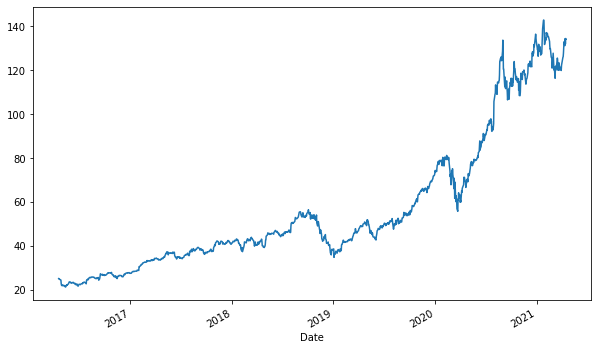

In [5]:
plt.figure(figsize=(10,6))
data['Adj Close'].plot()

<AxesSubplot:xlabel='Week Day', ylabel='Adj Close'>

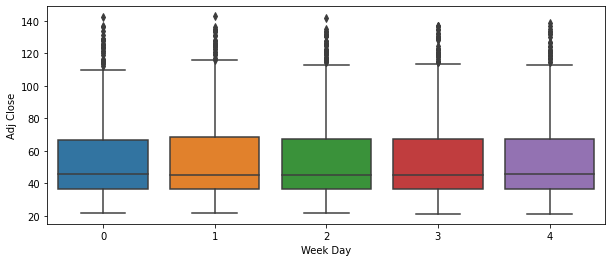

In [6]:
plt.figure(figsize=(10,4))
sns.boxplot(x='Week Day',y='Adj Close',data= data)

In [6]:
size = int(len(data)*0.9)
train, test = data['Adj Close'][:size], data['Adj Close'][size:]
train.shape, test.shape

((1133,), (126,))

In [7]:
#Ho: It is non stationary
#H1: It is stationary
def test_stationarity(timeseries):
    #Plot rolling statistics
    plt.figure(figsize=(10,6))
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red',label='Rolling Mean')
    std = plt.plot(rolstd, color='black',label='Rolling Std')
    
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag ='AIC')
    output = pd.Series(result[0:4],['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in result[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    if result[1] <= 0.05:
        print("\n Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("\n Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")  

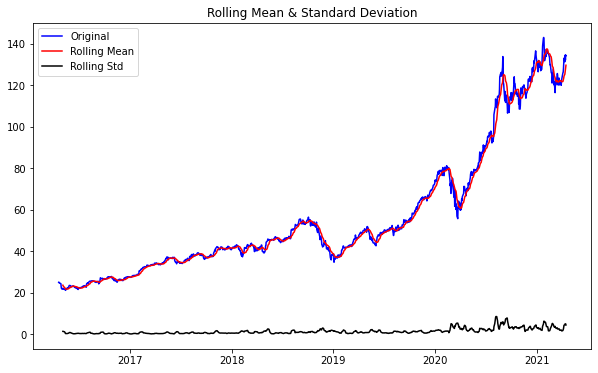

Results of Dickey-Fuller Test:
Test Statistic                    0.707072
p-value                           0.989978
#Lags Used                       20.000000
Number of Observations Used    1238.000000
Critical Value (1%)              -3.435643
Critical Value (5%)              -2.863877
Critical Value (10%)             -2.568014
dtype: float64

 Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [8]:
test_stationarity(data['Adj Close'])

After analysing the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

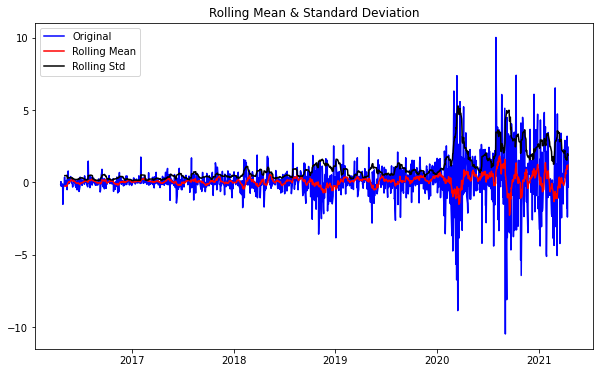

Results of Dickey-Fuller Test:
Test Statistic                -6.862311e+00
p-value                        1.590973e-09
#Lags Used                     1.900000e+01
Number of Observations Used    1.238000e+03
Critical Value (1%)           -3.435643e+00
Critical Value (5%)           -2.863877e+00
Critical Value (10%)          -2.568014e+00
dtype: float64

 Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [9]:
first_diff = data['Adj Close'] - data['Adj Close'].shift(1)
first_diff.dropna(inplace = True)
test_stationarity(first_diff)

<Figure size 432x288 with 0 Axes>

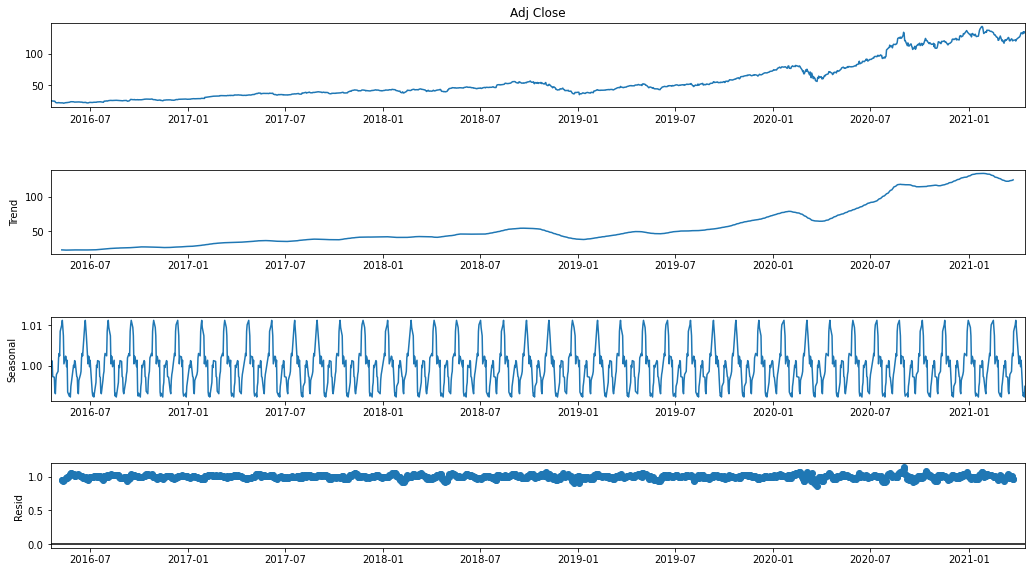

In [11]:
result = seasonal_decompose(data['Adj Close'], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

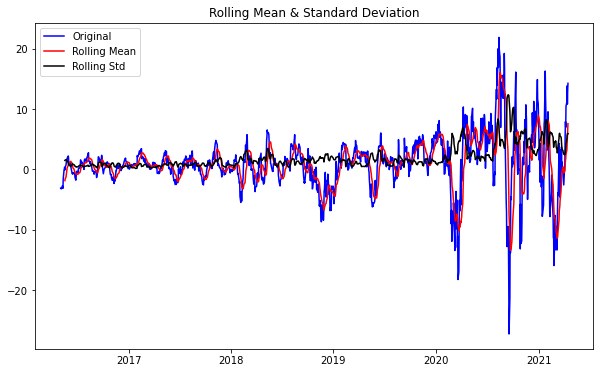

Results of Dickey-Fuller Test:
Test Statistic                -7.299375e+00
p-value                        1.351214e-10
#Lags Used                     2.300000e+01
Number of Observations Used    1.223000e+03
Critical Value (1%)           -3.435708e+00
Critical Value (5%)           -2.863906e+00
Critical Value (10%)          -2.568030e+00
dtype: float64

 Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [10]:
## Again test dickey fuller test
Seasonal_First_Difference =data['Adj Close']-data['Adj Close'].shift(12)
test_stationarity(Seasonal_First_Difference.dropna())

In [13]:
# # !pip install pmdarima
# from pmdarima.arima import auto_arima
# model_autoARIMA = auto_arima(train, start_p=0, start_q=0,
# test='adf',       # use adftest to find optimal 'd'
# max_p=12, max_q=3, # maximum p and q
# m=1,              # frequency of series
# d=None,           # let model determine 'd'
# seasonal=False,   # No Seasonality
# start_P=0, 
# D=0, 
# trace=True,
# error_action='ignore',  
# suppress_warnings=True, 
# stepwise=True)
# print(model_autoARIMA.summary())

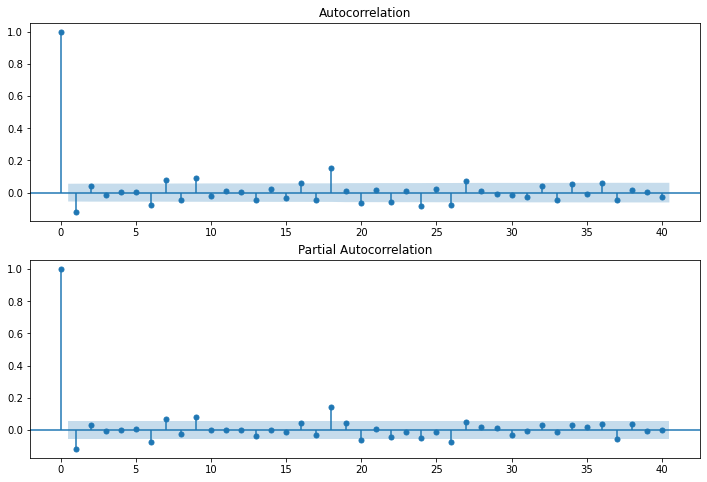

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(first_diff,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(first_diff,lags=40,ax=ax2)

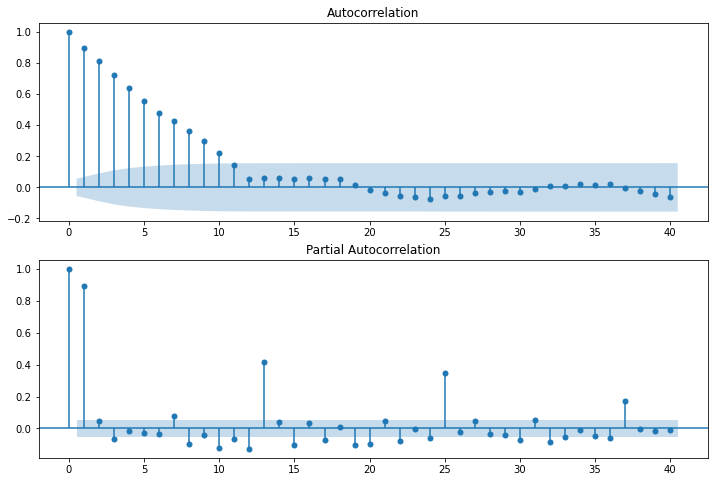

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(Seasonal_First_Difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Seasonal_First_Difference.iloc[13:],lags=40,ax=ax2)

In [35]:
warnings.filterwarnings('ignore')

p_values = range(0,6)
d_values = range(0,3)
q_values = range(0,5)

error_list = []
order_list = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                order = (p,d,q)
                pred = list()
                model=ARIMA(train,order)
                model_fit=model.fit()
                pred_y = model_fit.forecast(steps=len(test))[0]
                error = mean_squared_error(test,pred_y)
                order_list.append(order)
                error_list.append(error)
                print('ARIMA %s   MSE = %.2f'% (order,error))
            except:
                continue

ARIMA (0, 0, 0)   MSE = 5873.57
ARIMA (0, 0, 1)   MSE = 5842.01
ARIMA (0, 0, 2)   MSE = 5808.09
ARIMA (0, 0, 4)   MSE = 5774.07
ARIMA (0, 1, 0)   MSE = 46.23
ARIMA (0, 1, 1)   MSE = 46.32
ARIMA (0, 1, 2)   MSE = 46.10
ARIMA (0, 1, 3)   MSE = 45.82
ARIMA (0, 1, 4)   MSE = 46.05
ARIMA (0, 2, 0)   MSE = 49.49
ARIMA (0, 2, 1)   MSE = 162.80
ARIMA (0, 2, 2)   MSE = 164.26
ARIMA (0, 2, 3)   MSE = 161.68
ARIMA (0, 2, 4)   MSE = 157.96
ARIMA (1, 0, 0)   MSE = 76.25
ARIMA (1, 1, 0)   MSE = 46.23
ARIMA (1, 1, 1)   MSE = 46.00
ARIMA (1, 1, 2)   MSE = 46.15
ARIMA (1, 2, 0)   MSE = 8964.06
ARIMA (1, 2, 1)   MSE = 163.77
ARIMA (1, 2, 2)   MSE = 161.73
ARIMA (1, 2, 3)   MSE = 164.78
ARIMA (1, 2, 4)   MSE = 160.69
ARIMA (2, 0, 0)   MSE = 76.34
ARIMA (2, 1, 0)   MSE = 45.99
ARIMA (2, 1, 1)   MSE = 45.97
ARIMA (2, 1, 2)   MSE = 45.39
ARIMA (2, 1, 3)   MSE = 46.32
ARIMA (2, 2, 0)   MSE = 56.43
ARIMA (2, 2, 1)   MSE = 161.24
ARIMA (2, 2, 2)   MSE = 162.78
ARIMA (2, 2, 3)   MSE = 149.46
ARIMA (2, 2, 4)   M

In [36]:
i = error_list.index(min(error_list))
print('Min. Error ARIMA %s   MSE = %.2f'% (order_list[i],error_list[i]))

Min. Error ARIMA (4, 1, 4)   MSE = 45.22


In [45]:
warnings.filterwarnings('ignore')
# model=ARIMA(train,order=(order_list[i]))
model=ARIMA(train,order=(4, 1, 4))
model_fit=model.fit()
pred_y = model_fit.forecast(steps=len(test))[0]
error = mean_squared_error(test,pred_y)
error

45.22279737098718

In [46]:
start = train.shape[0]
end = data.shape[0]
start,end

(1133, 1259)

<AxesSubplot:xlabel='Date'>

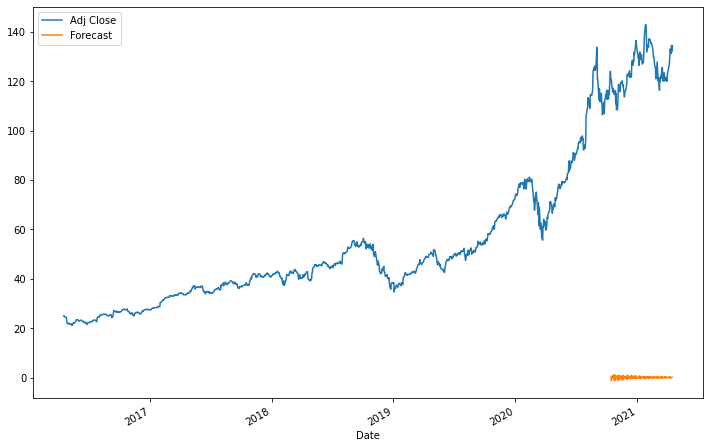

In [47]:
data['Forecast'] = np.nan
pred_y = model_fit.predict(start=start,end=end,dynamic=True)
for i in range(test.shape[0]):
    data['Forecast'].iloc[start-1+i] = pred_y.iloc[i]

data[['Adj Close','Forecast']].plot(figsize=(12,8))

In [49]:
warnings.filterwarnings('ignore' )
model=SARIMAX(train,order=(4, 1, 4),seasonal_order=(1,1,1,12))
model_fit=model.fit()
pred_y = model_fit.forecast(steps=len(test))
error = mean_squared_error(test,pred_y)
error

46.371885789580794

<AxesSubplot:xlabel='Date'>

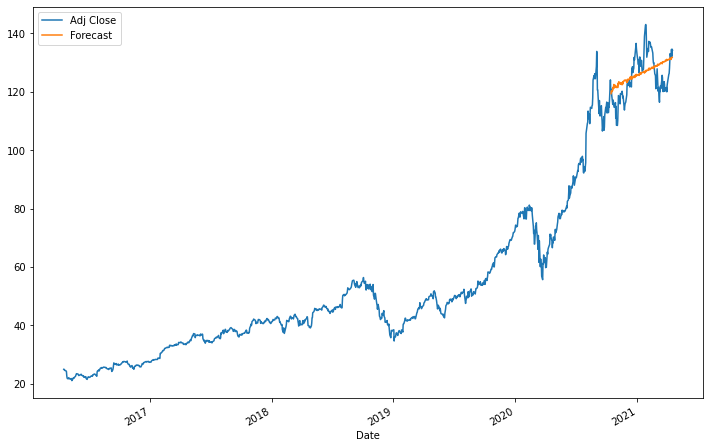

In [50]:
pred_y = model_fit.predict(start=start,end=end,dynamic=True)
for i in range(test.shape[0]):
    data['Forecast'].iloc[start-1+i] = pred_y.iloc[i]

data[['Adj Close','Forecast']].plot(figsize=(12,8))

In [51]:
from pandas.tseries.offsets import DateOffset
future_dates=[data.index[-1]+ DateOffset(days=x)for x in range(0,61)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=data.columns)

In [52]:
future_df=pd.concat([data,future_datest_df])
start = data.shape[0]+1
end = data.shape[0]+60
start,end

(1260, 1319)

<AxesSubplot:>

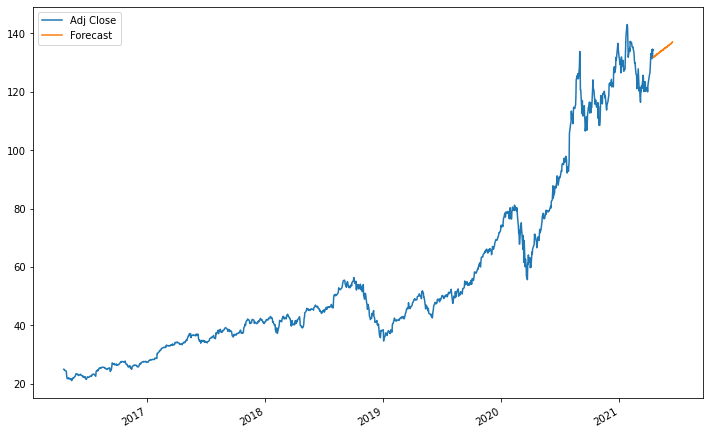

In [53]:
warnings.filterwarnings('ignore' )
future_df['Forecast'] = np.nan
pred_y = model_fit.predict(start = start , end = end, dynamic= True) 
for i in range(60):
    future_df['Forecast'].iloc[start-1+i] = pred_y.iloc[i]
future_df[['Adj Close', 'Forecast']].plot(figsize=(12, 8))